# Data Science Project: Identifying Future Travel Insurance Customers

## Import libraries

In [9]:
# Data structures
import pandas as pd 
import numpy as np 
import itertools
from collections import Counter

# Plotting
import matplotlib.pyplot as plt
from matplotlib import gridspec
import scikitplot as skplt 
import seaborn as sn

# Modelling
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn import tree
import statsmodels.api as sm
import pydotplus
from IPython.display import Image 

# Hide all warnings
import warnings
warnings.filterwarnings("ignore")

## 1. Import data and data  preparation

In [10]:
data = pd.read_csv('TravelInsurancePrediction.csv')

In [11]:
data.shape

(1987, 10)

In [12]:
data.head().style 

,Unnamed: 0,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
0,0,31,Government Sector,Yes,400000,6,1,No,No,0
1,1,31,Private Sector/Self Employed,Yes,1250000,7,0,No,No,0
2,2,34,Private Sector/Self Employed,Yes,500000,4,1,No,No,1
3,3,28,Private Sector/Self Employed,Yes,700000,3,1,No,No,0
4,4,28,Private Sector/Self Employed,Yes,700000,8,1,Yes,No,0


In [13]:
# Remove unnecessary index column
data = data.drop(['Unnamed: 0'], axis=1)

In [14]:
# Transform AnnualIncome from rupees to 10 000 rupees
data['AnnualIncome'] = data['AnnualIncome'] / 10000

#### Encode categorical variables

The variables `Employment Type`, `GraduateOrNot`, `FrequentFlyer` and `EverTravelledAbroad` are categorical and require label encoding so that the models can use them. We perform one-hot-encoding using Panda's "get_dummies()" function.

In [15]:
# Get dummy variables
data = pd.get_dummies(data, columns=["Employment Type", "GraduateOrNot", "FrequentFlyer", "EverTravelledAbroad"], prefix=["Employment Type", "GraduateOrNot", "FrequentFlyer", "EverTravelledAbroad"], drop_first=True) #Add a prefix for easier identification
# Rename dummy variables
data = data.rename(columns = {'Employment Type_Private Sector/Self Employed':'Employment_Type', 'GraduateOrNot_Yes':'Graduation_Status','FrequentFlyer_Yes':'Frequent_Flyer','EverTravelledAbroad_Yes':'Travelled_Abroad'})

In [16]:
# Check again if dataset looks like we wanted
data.head(10)

,Age,AnnualIncome,FamilyMembers,ChronicDiseases,TravelInsurance,Employment_Type,Graduation_Status,Frequent_Flyer,Travelled_Abroad
0,31,40.0,6,1,0,False,True,False,False
1,31,125.0,7,0,0,True,True,False,False
2,34,50.0,4,1,1,True,True,False,False
3,28,70.0,3,1,0,True,True,False,False
4,28,70.0,8,1,0,True,True,True,False
5,25,115.0,4,0,0,True,False,False,False
6,31,130.0,4,0,0,False,True,False,False
7,31,135.0,3,0,1,True,True,True,True
8,28,145.0,6,1,1,True,True,True,True
9,33,80.0,3,0,0,False,True,True,False


## 2. Exploratory data analysis (EDA)

In [17]:
data.info() 
# No null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1987 entries, 0 to 1986
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                1987 non-null   int64  
 1   AnnualIncome       1987 non-null   float64
 2   FamilyMembers      1987 non-null   int64  
 3   ChronicDiseases    1987 non-null   int64  
 4   TravelInsurance    1987 non-null   int64  
 5   Employment_Type    1987 non-null   bool   
 6   Graduation_Status  1987 non-null   bool   
 7   Frequent_Flyer     1987 non-null   bool   
 8   Travelled_Abroad   1987 non-null   bool   
dtypes: bool(4), float64(1), int64(4)
memory usage: 85.5 KB


In [18]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Age,1987.0,29.650226,2.913308,25.0,28.0,29.0,32.0,35.0
AnnualIncome,1987.0,93.276296,37.685568,30.0,60.0,90.0,125.0,180.0
FamilyMembers,1987.0,4.752894,1.609650,2.0,4.0,5.0,6.0,9.0
ChronicDiseases,1987.0,0.277806,0.448030,0.0,0.0,0.0,1.0,1.0
TravelInsurance,1987.0,0.357323,0.479332,0.0,0.0,0.0,1.0,1.0


Text(0.5, 1.0, 'Correlation between variables')

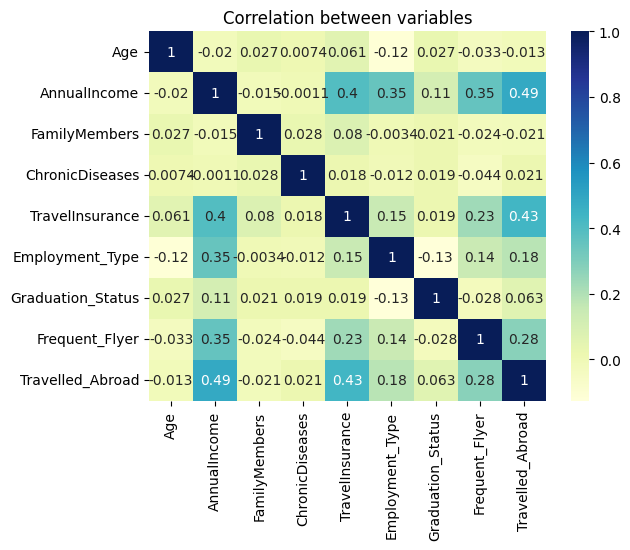

In [19]:
# Correlations between variables
sn.heatmap(data.corr(),annot=True, cmap = "YlGnBu").set_title('Correlation between variables')

## 3. Data visualization

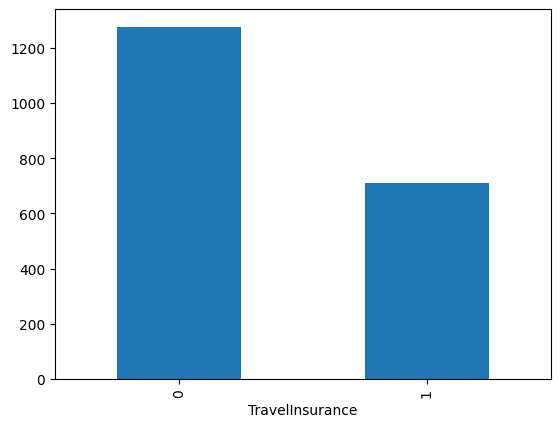

In [20]:
#Visualize the target variable 
ax = data['TravelInsurance'].value_counts().plot(kind='bar')

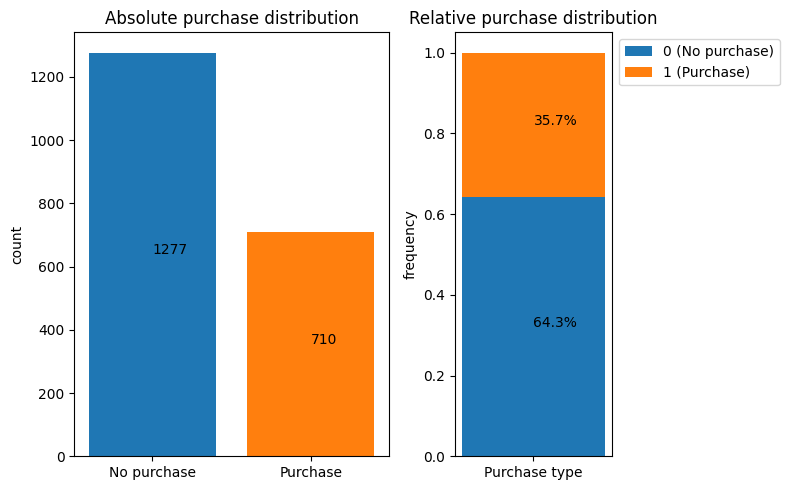

In [21]:
# plot number of purchases of travel insurance
keys, counts = np.unique(data.TravelInsurance, return_counts=True)
counts_norm = counts/counts.sum()

fig = plt.figure(figsize=(8, 5)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[2,1]) 

#Absolute values
ax0 = plt.subplot(gs[0])
ax0 = plt.bar(['No purchase', 'Purchase'], counts, color=['#1f77b4','#ff7f0e'])
ax0 = plt.title('Absolute purchase distribution') 
ax0 = plt.ylabel('count')
ax0 = plt.text(keys[0], counts[0]/2, counts[0]) 
ax0 = plt.text(keys[1], counts[1]/2, counts[1]) 

#Normalized values
ax1 = plt.subplot(gs[1])
ax1 = plt.bar(['Purchase type'], [counts_norm[0]], label='0 (No purchase)')
ax1 = plt.bar(['Purchase type'], [counts_norm[1]], bottom=counts_norm[0], label='1 (Purchase)')
ax1 = plt.legend(bbox_to_anchor=(1, 1))
ax1 = plt.title('Relative purchase distribution')
ax1 = plt.ylabel('frequency')
ax1 = plt.text(['Purchase type'],counts_norm[0]/2, '{}%'.format((counts_norm[0]*100).round(1)))
ax1 = plt.text(['Purchase type'],(counts_norm[1]/2)+counts_norm[0], '{}%'.format((counts_norm[1]*100).round(1)))

plt.tight_layout()
plt.show()

## 4. Divide data into response variable Y and dataset of independent variables X

In [22]:
#define feature matrix X and labels y
X, y = data[['Age', 
             'Employment_Type', 
             'Graduation_Status', 
             'AnnualIncome',
             'FamilyMembers',
             'ChronicDiseases',
             'Frequent_Flyer',
             'Travelled_Abroad']], data['TravelInsurance'] 

In [23]:
X.head()

,Age,Employment_Type,Graduation_Status,AnnualIncome,FamilyMembers,ChronicDiseases,Frequent_Flyer,Travelled_Abroad
0,31,False,True,40.0,6,1,False,False
1,31,True,True,125.0,7,0,False,False
2,34,True,True,50.0,4,1,False,False
3,28,True,True,70.0,3,1,False,False
4,28,True,True,70.0,8,1,True,False


In [24]:
y.head()

0    0
1    0
2    1
3    0
4    0
Name: TravelInsurance, dtype: int64

## 5. Data split

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1234) #split data 70:30

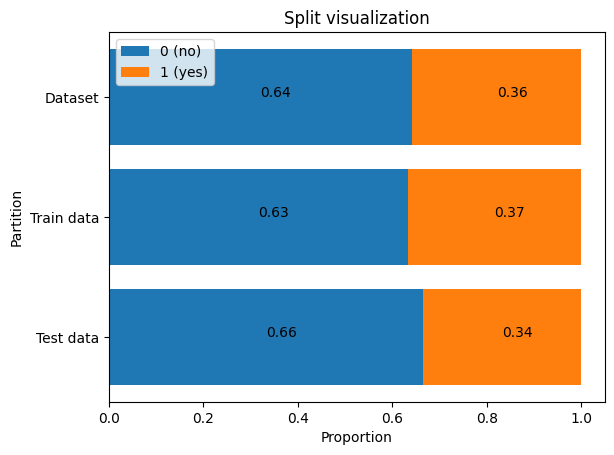

In [26]:
train_dist = y_train.value_counts() / len(y_train) #normalize absolute count values for plotting
test_dist = y_test.value_counts() / len(y_test)
data_dist = y.value_counts() / len(y)

fig, ax = plt.subplots()

ax.barh(['Test data','Train data','Dataset'], [test_dist[0], train_dist[0], data_dist[0]], color='#1f77b4', label='0 (no)')
ax.barh(['Test data','Train data','Dataset'], [test_dist[1], train_dist[1], data_dist[1]], left=[test_dist[0], train_dist[0], data_dist[0]], color='#ff7f0e', label='1 (yes)')
ax.set_title('Split visualization')
ax.legend(loc='upper left')
plt.xlabel('Proportion')
plt.ylabel('Partition')

#plot bar values
for part, a, b in zip(['Test data', 'Train data','Dataset'], [test_dist[0], train_dist[0], data_dist[0]], [test_dist[1], train_dist[1], data_dist[1]]):
    plt.text(a/2, part, str(np.round(a, 2)))
    plt.text(b/2+a, part, str(np.round(b, 2)));

## 6. Rebalancing with SMOTE

In [27]:
smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_resample(X_train, y_train)

#### Plotting data split ratios

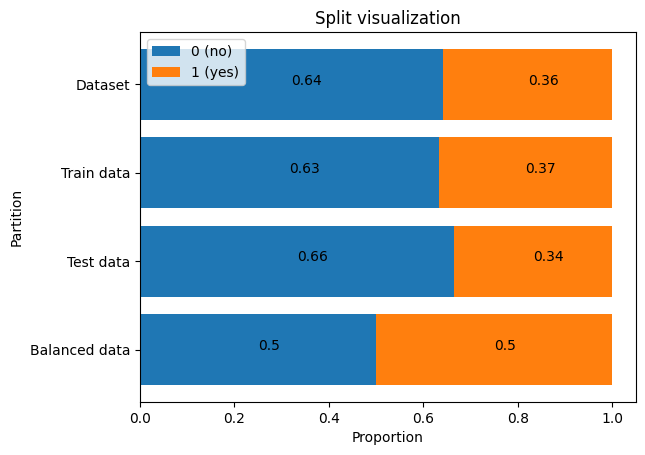

In [28]:
train_dist = y_train.value_counts() / len(y_train) #normalize absolute count values for plotting
test_dist = y_test.value_counts() / len(y_test)
data_dist = y.value_counts() / len(y)
smote_dist = pd.Series(y_sm).value_counts() / len(pd.Series(y_sm))

fig, ax = plt.subplots()

ax.barh(['Balanced data','Test data','Train data','Dataset'], [smote_dist[0], test_dist[0], train_dist[0], data_dist[0]], color='#1f77b4', label='0 (no)')
ax.barh(['Balanced data','Test data','Train data','Dataset'], [smote_dist[1], test_dist[1], train_dist[1], data_dist[1]], left=[smote_dist[0], test_dist[0], train_dist[0], data_dist[0]], color='#ff7f0e', label='1 (yes)')
ax.set_title('Split visualization')
ax.legend(loc='upper left')
plt.xlabel('Proportion')
plt.ylabel('Partition')

#plot bar values
for part, a, b in zip(['Balanced data', 'Test data', 'Train data','Dataset'], [smote_dist[0], test_dist[0], train_dist[0], data_dist[0]], [smote_dist[1], test_dist[1], train_dist[1], data_dist[1]]):
    plt.text(a/2, part, str(np.round(a, 2)))
    plt.text(b/2+a, part, str(np.round(b, 2)));

## 7. Model building

### 7.1 Logistic Regression

#### 7.1.1 Logistic Regression summary

In [29]:
# To get an idea about relationships between variables we print the logistic regression summary
lr_model = sm.Logit(y, sm.add_constant(X.astype(float)))
lr_result = lr_model.fit()
print(lr_result.summary())

Optimization terminated successfully.
         Current function value: 0.520462
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:        TravelInsurance   No. Observations:                 1987
Model:                          Logit   Df Residuals:                     1978
Method:                           MLE   Df Model:                            8
Date:                Wed, 02 Aug 2023   Pseudo R-squ.:                  0.2016
Time:                        09:56:58   Log-Likelihood:                -1034.2
converged:                       True   LL-Null:                       -1295.3
Covariance Type:            nonrobust   LLR p-value:                1.219e-107
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -5.4047      0.634     -8.525      0.000      -6.647      -4.162
Age     

#### 7.1.1 Imbalanced data
To highlight the positive effect of rebalancing, we first train a model on the original, unbalanced data set. Note that this is purely for illustrative purposes and would not be done in an actual assignment.

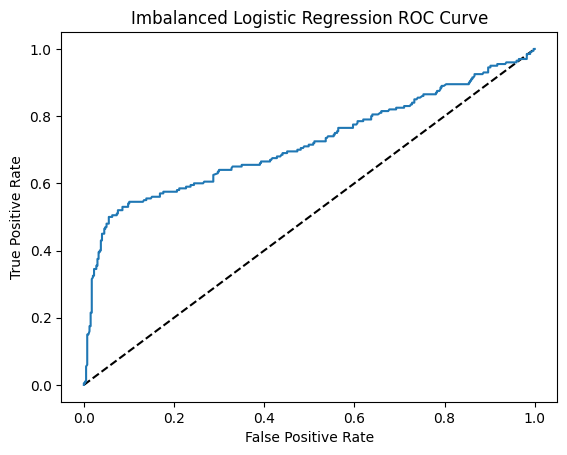

AUC is:  0.72
Accuracy is:  78.39


In [30]:
# Imbalanced model
lr_imb = LogisticRegression(random_state=1234, max_iter=20).fit(X_train, y_train)
y_pred_lr_imb = lr_imb.predict(X_test)
y_predProba_lr_imb = lr_imb.predict_proba(X_test)

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_predProba_lr_imb[:,1])
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Imbalanced Logistic Regression ROC Curve')
plt.show()

# AUC
print("AUC is: ", roc_auc_score(y_test, y_predProba_lr_imb[:,1]).round(2))
print ("Accuracy is: ", (accuracy_score(y_test, y_pred_lr_imb)*100).round(2))

Previously imbalanced logistic regression model was only able to make negative classifications and ROC curve only ~0.25. Scaling AnnualIncome by dividing it by 10 000 fixed the problem with the model. Now the model is able to classify positives and ROC curve makes more sense.

#### 7.1.2 Balanced data (SMOTE)

Next, we train the actual Logistic Regression model using the rebalanced data.

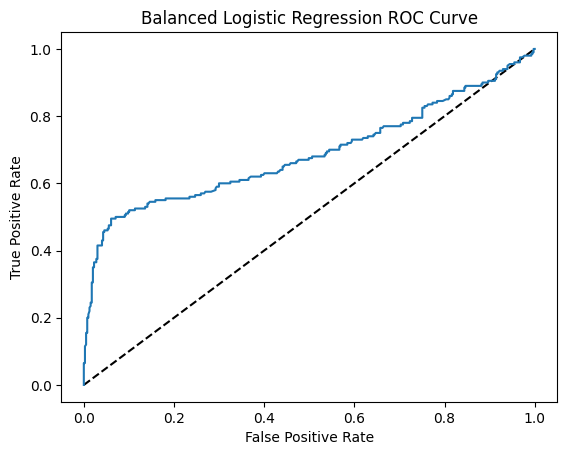

AUC is:  0.69
Accuracy is:  67.67


In [31]:
# Balanced model
lr_bal = LogisticRegression(random_state=1234, max_iter=20).fit(X_sm, y_sm)
y_pred_lr_bal = lr_bal.predict(X_test)
y_predProba_lr_bal = lr_bal.predict_proba(X_test)

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_predProba_lr_bal[:,1])
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Balanced Logistic Regression ROC Curve')
plt.show()

# AUC
print("AUC is: ", (roc_auc_score(y_test, y_predProba_lr_bal[:,1])).round(2))
print("Accuracy is: ", (accuracy_score(y_test, y_pred_lr_bal)*100).round(2))

### 7.2 Support-vector machine (SVM)

In order to compare models, we also train another classifier using SVM. 

#### 7.2.1 Imbalanced SVM

In [32]:
svm_imb = SVC(probability=True).fit(X_train, y_train)

In [33]:
y_pred_svm_imb = svm_imb.predict(X_test)
y_predProba_svm_imb = svm_imb.predict_proba(X_test)
print ("Accuracy is: ", (accuracy_score(y_test, y_pred_svm_imb)*100).round(2))

Accuracy is:  78.22


#### 7.2.2 Imbalanced SVM

In [34]:
svm_bal = SVC(probability=True).fit(X_sm, y_sm)

In [35]:
y_pred_svm_bal = svm_bal.predict(X_test)
y_predProba_svm_bal = svm_bal.predict_proba(X_test)
print ("Accuracy is: ", (accuracy_score(y_test, y_pred_svm_bal)*100).round(2))

Accuracy is:  75.04


## 7.3 Decision tree models

#### 7.3.1 Unbalanced Decision Tree Model

In [36]:
tree_imb = tree.DecisionTreeClassifier(criterion = "gini", random_state = 100,
                               max_depth=3, min_samples_leaf=3).fit(X_train, y_train)

tree_imb = tree_imb.fit(X_train, y_train)

In [37]:
y_pred_tree_imb = tree_imb.predict(X_test)
y_predProba_tree_imb = tree_imb.predict_proba(X_test)

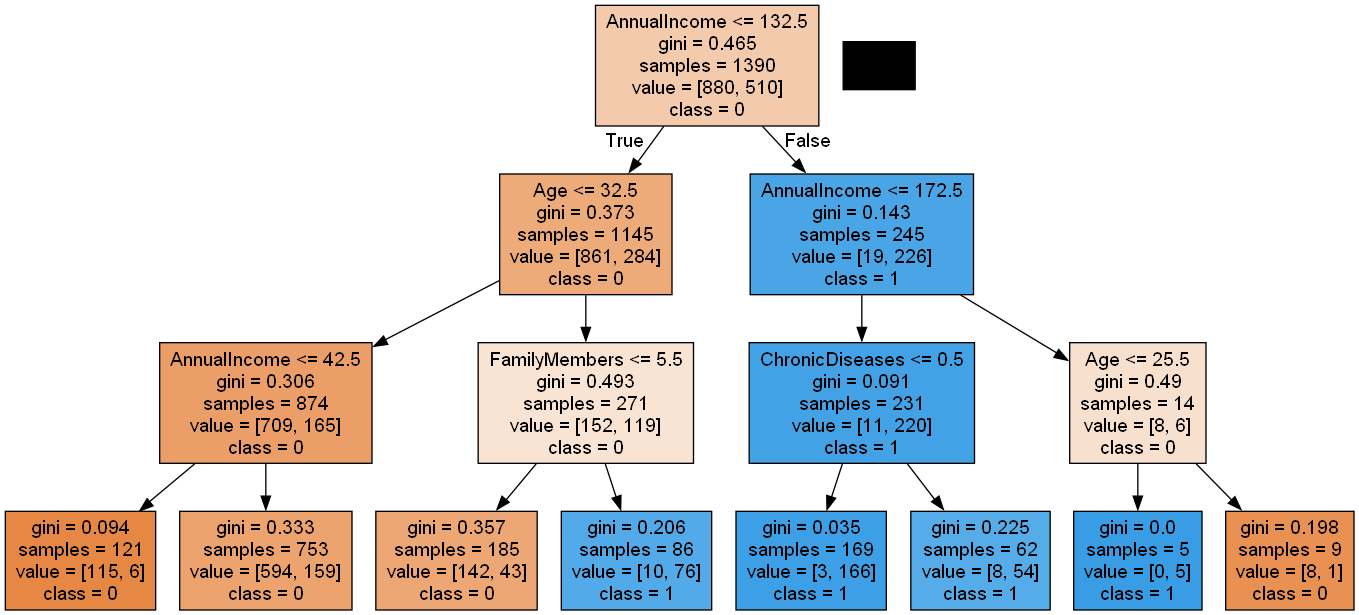

In [38]:
dot_data = tree.export_graphviz(tree_imb, out_file=None, 
                                feature_names=X_train.columns, 
                                class_names=['0', '1'], filled=True) 

graph = pydotplus.graph_from_dot_data(dot_data)  

Image(graph.create_png())

In [39]:
print ("Accuracy is: ", (accuracy_score(y_test, y_pred_tree_imb)*100).round(2))

Accuracy is:  83.92


The classifier correctly identifies customers who decided to buy a travel insurance with almost 84% of the observations. This can be considered a good score.

In [40]:
importances = tree_imb.feature_importances_
indices = np.argsort(importances)[::-1]
feature_order = np.array([X.columns.values])
i = np.argsort(importances)[::-1]
feature_order = feature_order[:,i]

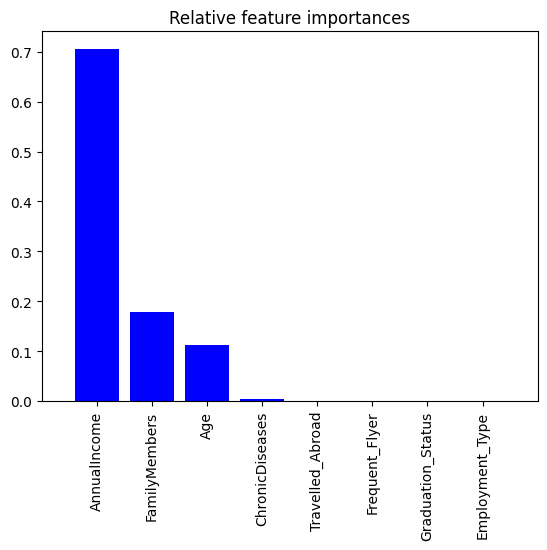

In [41]:
plt.figure()
plt.title("Relative feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="b",  align="center")
plt.xticks(range(X.shape[1]), feature_order[0], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

According to the unbalanced Decision Tree model, the significant features are annual income, family members and age. Chronic diseases are not seen as a major factor among customers.

#### 7.3.2 Balanced Decision Tree Model 

In [42]:
tree_bal = tree.DecisionTreeClassifier(criterion = "gini", random_state = 100,
                               max_depth=3, min_samples_leaf=3).fit(X_sm, y_sm)


y_pred_tree_bal = tree_bal.predict(X_test) 
y_predProba_tree_bal = tree_bal.predict_proba(X_test)
print ("Accuracy is: ", (accuracy_score(y_test, y_pred_tree_bal)*100).round(2))

Accuracy is:  82.75


## 8. Model evaluation

### 1. Confusion Matrix

In [43]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting 'normalize=True'.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylim([1.5, -0.5]) 
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

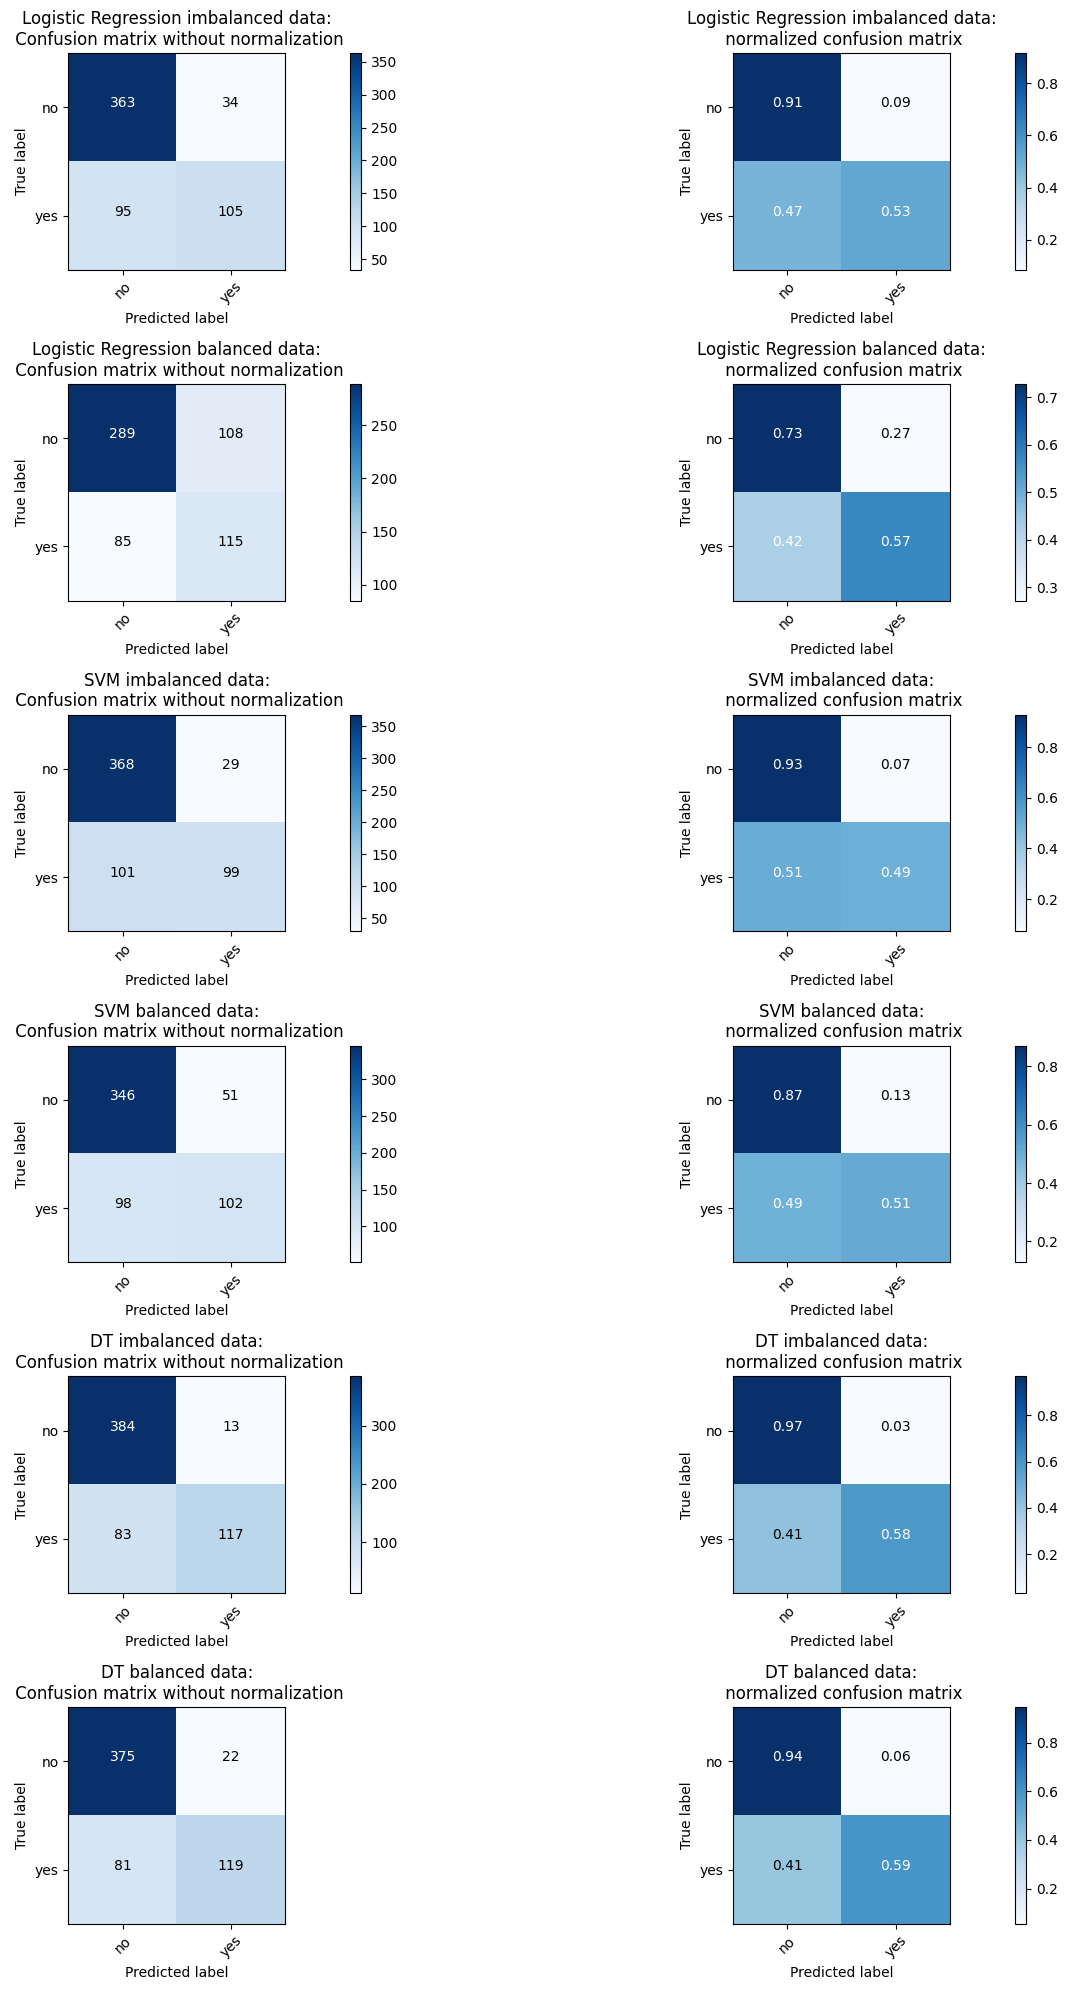

In [44]:
# Compute confusion matrix
class_names = ['no', 'yes']
cnf_matrix_lr_imb = confusion_matrix(y_test, y_pred_lr_imb)
cnf_matrix_lr_bal = confusion_matrix(y_test, y_pred_lr_bal)
cnf_matrix_svm = confusion_matrix(y_test, y_pred_svm_bal)
cnf_matrix_svm_imb = confusion_matrix(y_test, y_pred_svm_imb)
cnf_matrix_dt_bal = confusion_matrix(y_test, y_pred_tree_bal)
cnf_matrix_dt_imb = confusion_matrix(y_test, y_pred_tree_imb)

np.set_printoptions(precision=2)

plt.figure(figsize=(20, 20))

#Plot Logistic Regression (imbalanced) confusion matrix
plt.subplot(6,2,1) 
plot_confusion_matrix(cnf_matrix_lr_imb, classes=class_names,
                      title='Logistic Regression imbalanced data:\n Confusion matrix without normalization')

#Plot Logistic Regression (imbalanced) normalized confusion matrix
plt.subplot(6,2,2) 
plot_confusion_matrix(cnf_matrix_lr_imb, classes=class_names, normalize=True,
                      title='Logistic Regression imbalanced data:\n normalized confusion matrix')


#Plot Logistic Regression (balanced) confusion matrix
plt.subplot(6,2,3) 
plot_confusion_matrix(cnf_matrix_lr_bal, classes=class_names,
                      title='Logistic Regression balanced data:\n Confusion matrix without normalization')

#Plot Logistic Regression (balanced) normalized onfusion matrix
plt.subplot(6,2,4) 
plot_confusion_matrix(cnf_matrix_lr_bal, classes=class_names, normalize=True,
                      title='Logistic Regression balanced data:\n normalized confusion matrix')

#Plot SVM imbalanced confusion matrix
plt.subplot(6,2,5) 
plot_confusion_matrix(cnf_matrix_svm_imb, classes=class_names,
                      title='SVM imbalanced data:\n Confusion matrix without normalization')

#Plot SVM imbalanced normalized confusion matrix
plt.subplot(6,2,6) 
plot_confusion_matrix(cnf_matrix_svm_imb, classes=class_names, normalize=True,
                      title='SVM imbalanced data:\n normalized confusion matrix')

#Plot SVM balanced confusion matrix
plt.subplot(6,2,7) 
plot_confusion_matrix(cnf_matrix_svm, classes=class_names,
                      title='SVM balanced data:\n Confusion matrix without normalization')

#Plot SVM balanced normalized confusion matrix
plt.subplot(6,2,8) 
plot_confusion_matrix(cnf_matrix_svm, classes=class_names, normalize=True,
                      title='SVM balanced data:\n normalized confusion matrix')

#Plot Decision Tree imbalanced confusion matrix
plt.subplot(6,2,9)
plot_confusion_matrix(cnf_matrix_dt_imb, classes=class_names,
                      title='DT imbalanced data:\n Confusion matrix without normalization')

#Plot Decision Tree imbalanced normalized confusion matrix
plt.subplot(6,2,10)
plot_confusion_matrix(cnf_matrix_dt_imb, classes=class_names, normalize=True,
                      title='DT imbalanced data:\n normalized confusion matrix')

#Plot Decision Tree balanced confusion matrix
plt.subplot(6,2,11)
plot_confusion_matrix(cnf_matrix_dt_bal, classes=class_names,
                      title='DT balanced data:\n Confusion matrix without normalization')

#Plot Decision Tree balanced normalized confusion matrix
plt.subplot(6,2,12)
plot_confusion_matrix(cnf_matrix_dt_bal, classes=class_names, normalize=True,
                      title='DT balanced data:\n normalized confusion matrix')


plt.show()

### 2. AUC and ROC

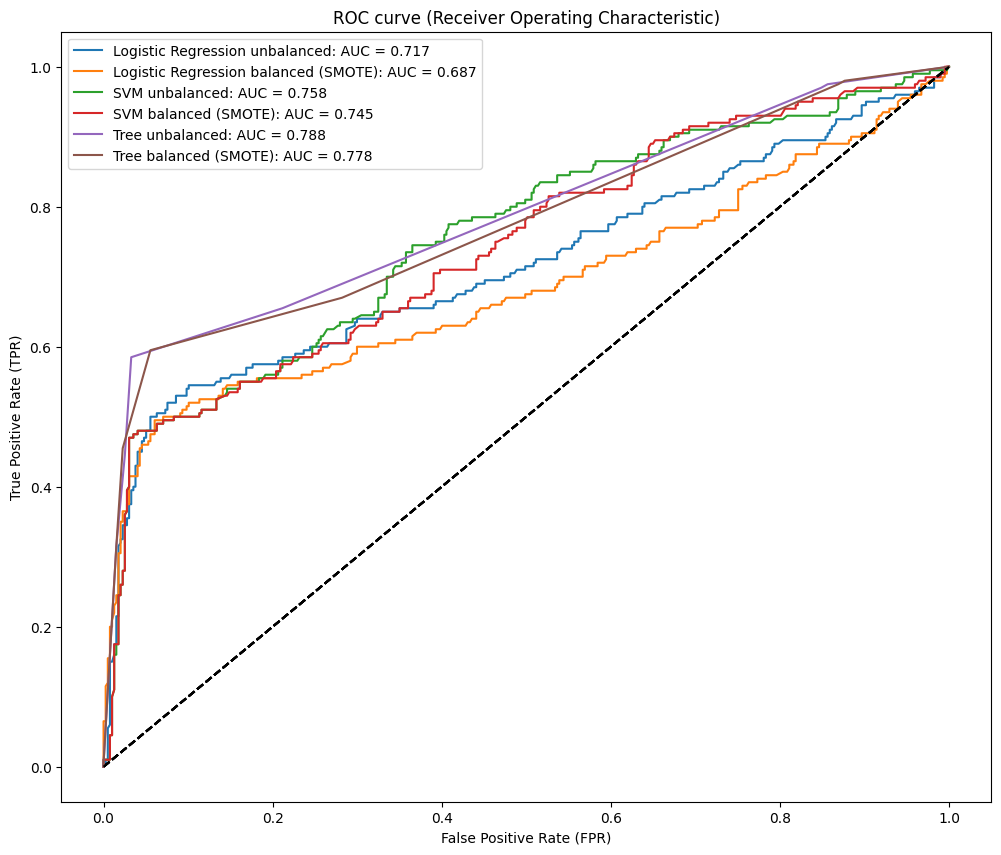

In [45]:
plt.figure(figsize=(12,10))


for test, pred, name in zip([y_test, y_test, y_test, y_test, y_test, y_test], [y_predProba_lr_imb[:,1], y_predProba_lr_bal[:,1], y_predProba_svm_imb[:,1], y_predProba_svm_bal[:,1], y_predProba_tree_imb[:,1], y_predProba_tree_bal[:,1]], ['Logistic Regression unbalanced','Logistic Regression balanced (SMOTE)', 'SVM unbalanced', 'SVM balanced (SMOTE)', 'Tree unbalanced', 'Tree balanced (SMOTE)']):
    fpr, tpr, _ = roc_curve(test, pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='{}: AUC = {}'.format(name, round(roc_auc, 3)))
    plt.legend(loc='best')
    plt.plot([0,1],[0,1],color='black', linestyle='--')


plt.title('ROC curve (Receiver Operating Characteristic)')    
plt.ylabel('True Positive Rate (TPR)')
plt.xlabel('False Positive Rate (FPR)')


plt.show()

### 3. Cumulative Response Curve, aka. Gains chart

- A Gain chart plots the **gain** (percentage of positives correctly classified by model; tp rate; hit rate) as a function of the **percentage of the population** that is targeted (decreasing by score)
- The diagonal x=y represents a random classifier; any classifier that is above the diagonal is providing some advantage

A wide gap between a random classifier (baseline) and a model indicates a high performance advantage in using said model. 

The cumulative gains graph can be used to estimate how many customers one should address to make a certain profit. Indeed, the cumulative gains graph shows which percentage of all targets is reached when addressing a certain percentage of the population.

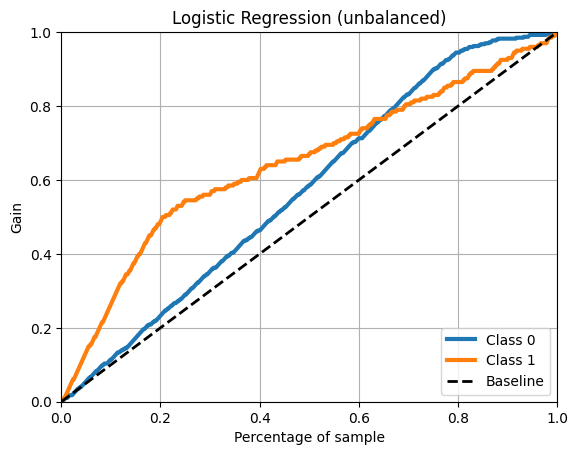

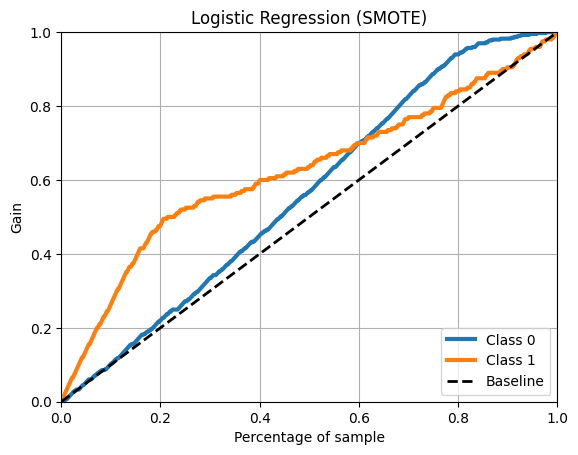

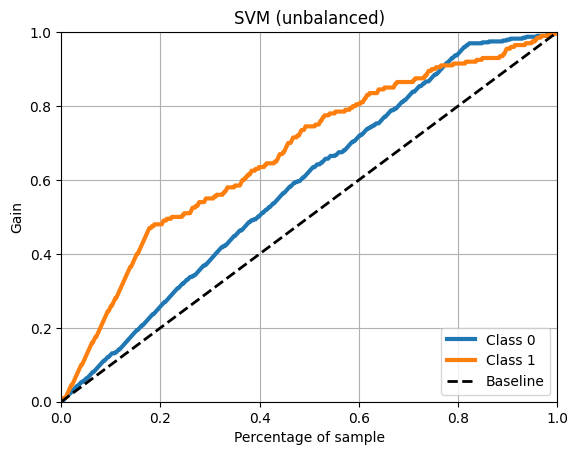

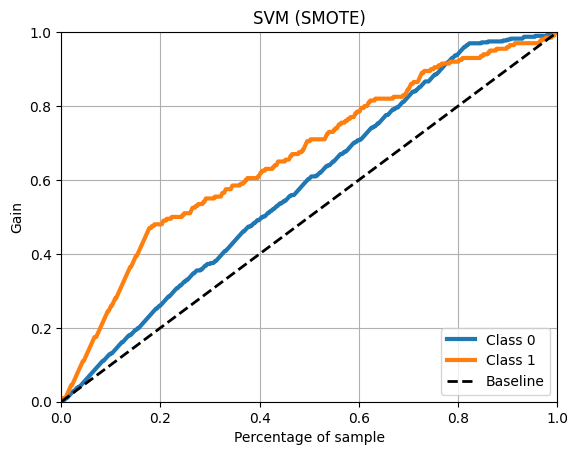

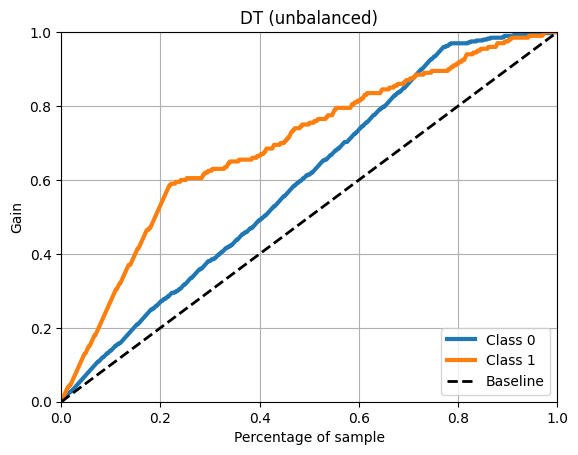

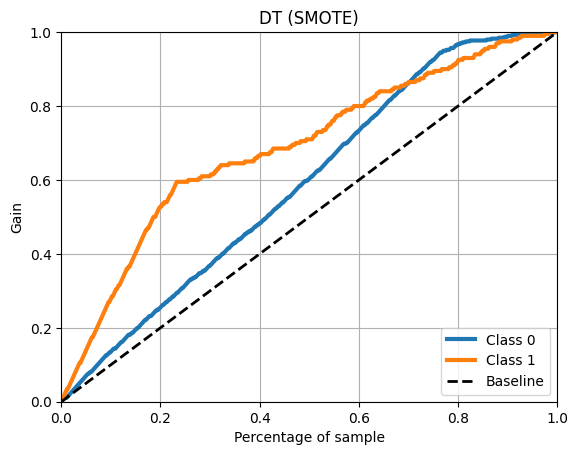

In [46]:
skplt.metrics.plot_cumulative_gain(y_test, y_predProba_lr_imb, title='Logistic Regression (unbalanced)')
skplt.metrics.plot_cumulative_gain(y_test, y_predProba_lr_bal, title='Logistic Regression (SMOTE)')
skplt.metrics.plot_cumulative_gain(y_test, y_predProba_svm_imb, title='SVM (unbalanced)');
skplt.metrics.plot_cumulative_gain(y_test, y_predProba_svm_bal, title='SVM (SMOTE)');
skplt.metrics.plot_cumulative_gain(y_test, y_predProba_tree_imb, title='DT (unbalanced)');
skplt.metrics.plot_cumulative_gain(y_test, y_predProba_tree_bal, title='DT (SMOTE)');